This file is basically the same as random_perturbations_logdi except generalized to multiple p's. 

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import model_bias_analysis
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # comment this out if higher resolution is not needed

In [2]:
# Remember to always check that these files look the way you want before you run this! see data-di-with-gay to regenerate

joined_tox = pd.read_csv('joined_tox.csv')
train_comments = pd.read_csv('train_comments.csv')
test_comments = pd.read_csv('test_comments.csv')
madlibs_terms = ['gay', 'homosexual', 'straight', 'black', 'white', 'american', 'jewish', 'old']

In [3]:
# Generates perturbations.
# Basically, creates num_perturbations number of arrays.
# Each array is the length of train_comments.
# Each element in each array is 0 or 1.
# For each element, with probability p, we replace it.
# What do we replace it with? A zero or one, chosen at random. (np.random.randint(2)).

def generate_perturbation_on_training(train_comments, num_perturbations, p):
    print("Probability p, with which we replace a label: ", p)
    
    list_perturbation = []
    rand = []
    tox_tmp = []
    num_replaced = 0
    
    length = len(train_comments.binary_tox.values)
    for j in range(num_perturbations):
        rand = np.random.random(length) # generate a random number (between 0 and 1) for each comment
        tox_tmp = np.copy(train_comments.binary_tox.values) # np.copy(tox_np)
        for i in range(length):
            if rand[i] <= p: # if random number is less than p, replace value in array with a random integer from {0, 1}
                tox_tmp[i] = np.random.randint(2)
                num_replaced += 1
        list_perturbation.append(tox_tmp)

    # each item in list_perturbation is a list of 0s and 1s that correspond to the new binary_tox of each variable
    print(num_replaced)
    return list_perturbation

In [4]:
def train_and_predict(train_comments, list_perturbations_training, test_comments, NUM_PERTURBATIONS):

    # This trains a logistic regression classifier on each perturbed dataset.
    d={}
    for x in range(NUM_PERTURBATIONS):
        d["clf{0}".format(x)] = Pipeline([
            ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
            ('tfidf', TfidfTransformer(norm = 'l2')),
            ('clf', LogisticRegression()),
        ])
        d["clf{0}".format(x)] = d["clf{0}".format(x)].\
                                    fit(train_comments['comment'], list_perturbations_training[x])
        d["auc{0}".format(x)] = roc_auc_score(test_comments['binary_tox'], \
                                    d["clf{0}".format(x)].predict_proba(test_comments['comment'])[:, 1])
        print('x Test ROC AUC: %.5f' %d["auc{0}".format(x)])
        
    # After training classifiers, we use them to predict labels for our test datasets!
    perturbed_predictions = [] # Each element is an array of predicted labels.
    # The 0th element is an array of predicted labels for the 0th perturbed dataset.

    for i in range(NUM_PERTURBATIONS):
        perturbed_predictions.append(d["clf{0}".format(i)].predict(test_comments['comment']))
                                                                                 
    return perturbed_predictions

In [7]:
def logDI(df, labels_col, terms):
    # labels_col is true/false of the comment being classified as toxic. ('binary_tox' I believe)
    # terms should be the array of top 8 terms
    
    logDI_arr = np.empty(((len(terms)), len(terms)))
    
    for i in range(len(terms)):
        for j in range(len(terms)):
            # print("******", i)
            logDI_arr[i, j] =  (math.log(len(df[(df[terms[i]]==True) & (df[labels_col]==True)]) / len(df[df[terms[i]]==True])) \
                            - math.log(len(df[(df[terms[j]]==True) & (df[labels_col]==True)]) / len(df[df[terms[j]]==True])))**2
                
    logDI = logDI_arr.sum() / 2
    return logDI

In [8]:
# The below function doesn't find an AVERAGE LogDI, does it?
# It just puts the LogDI for each perturbation into a list.

def find_avg_logDI(list_perturbations, df, madlibs_terms):
    # find logDI for each item in list_perturbations_training
    logs = []
    for i in range(len(list_perturbations)):
        namecol = 'perturbation' + str(i)
        df[namecol] = list_perturbations[i]
        logs.append(logDI(df, namecol, madlibs_terms))
    return logs

In [55]:
# p_vals = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] # np.arange(0, 1.1, 0.1)
p_vals = np.arange(0, 1.25, 0.25)
logs_training = [] # means
logs_test = [] # means
list_training = [] # perturbations
list_test = [] # perturbations

xs_all_logs = [] # corresponds to below
all_logs_training = [] # not means
all_logs_test = [] # not means
logs_training_list = [] # temp
logs_test_list = [] # temp

NUM_PERTURBATIONS = 25 # This is the number of perturbations we're doing on EACH p-val below
for i in range(len(p_vals)):
    p = p_vals[i]
    
    list_perturbations_training = generate_perturbation_on_training(train_comments, NUM_PERTURBATIONS, p)
    list_training.append(list_perturbations_training)
    
    logs_training_list = find_avg_logDI(list_perturbations_training, train_comments, madlibs_terms)
    
    logs_training.append(np.mean(logs_training_list)) # NP: I want to return to this line later.
    # NP: I'm not sure we should be taking any averages. But I could be mistaken.
        # I think I'll run it as is for now.
    
    all_logs_training.append(logs_training_list)
    xs_all_logs.append([p_vals[i]]*NUM_PERTURBATIONS)
    
    perturbed_predictions = train_and_predict(train_comments, list_perturbations_training, test_comments, NUM_PERTURBATIONS)
    list_test.append(perturbed_predictions)
    
    logs_test_list = find_avg_logDI(perturbed_predictions, test_comments, madlibs_terms)
    logs_test.append(np.mean(logs_test_list))
    all_logs_test.append(logs_test_list)
    

Probability p, with which we replace a label:  0.0
0
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
x Test ROC AUC: 0.95071
Probability p, with which we replace a label:  0.25
597805
x Test ROC AUC: 0.93123
x Test ROC AUC: 0.92951
x Test ROC AUC: 0.93377
x Test ROC AUC: 0.93112
x Test ROC AUC: 0.92989
x Test ROC AUC: 0.93125
x Test ROC AUC: 0.93302
x Test ROC AUC: 0.92893
x Test ROC AUC: 0.93244
x Test ROC AUC: 0.93043
x Test ROC AUC: 0.92971
x Test ROC AUC: 0.93088


In the below six cells, I disobey Neha and attempt to save the lists all_logs_training and all_logs_test to file. Hope it works!

In [56]:
import pickle

In [57]:
all_logs_training_file = "all_logs_training"

In [58]:
fileObject = open(all_logs_training_file, 'wb')

In [59]:
pickle.dump(all_logs_training, fileObject)

In [60]:
fileObject.close()

In [61]:
all_logs_test_file = "all_logs_test"
fileObject = open(all_logs_test_file, 'wb')
pickle.dump(all_logs_test, fileObject)
fileObject.close()

In the below three cells, I save our results to a dataframe [[p, LogDI(train), LogDI(test)]]. Then I save this to a CSV.

In [94]:
list_p = []
for i in p_vals:
    for j in range(25):
        list_p.append(i)
list_p

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.25,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 0.75,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [108]:
results = pd.DataFrame(list(zip(list_p, all_logs_training, all_logs_test)), columns=['p', 'logDI_train', 'logDI_test'])

In [109]:
results.to_csv('results/perturbation_results.csv')

Text(0,0.5,'Test Data log DI of two terms')

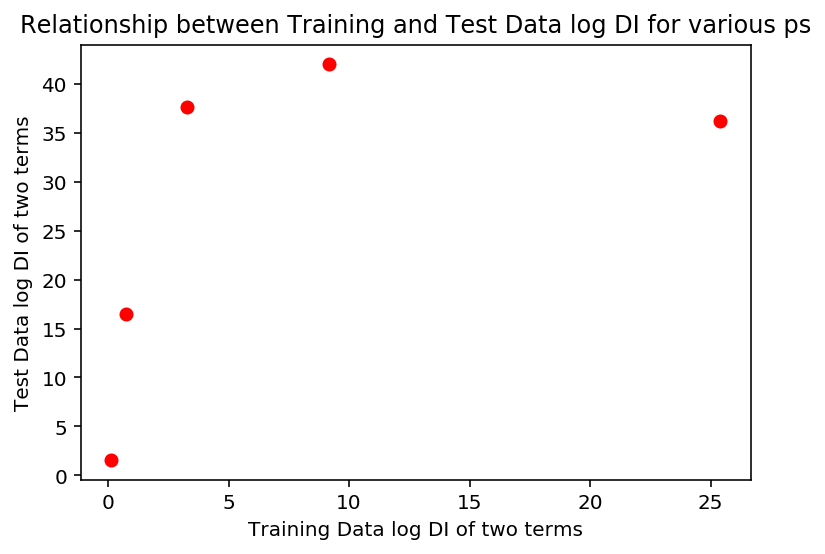

In [62]:
plt.plot(logs_training, logs_test, "ro")
plt.title("Relationship between Training and Test Data log DI for various ps")
plt.xlabel("Training Data log DI of two terms")
plt.ylabel("Test Data log DI of two terms")

Text(0,0.5,'log DI of training')

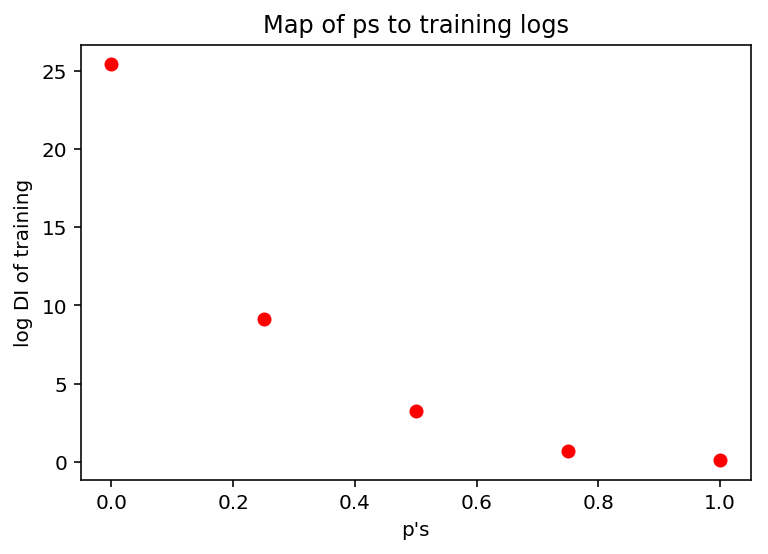

In [63]:
plt.plot(p_vals, logs_training, "ro")
plt.title("Map of ps to training logs")
plt.xlabel("p's")
plt.ylabel("log DI of training")

Text(0,0.5,'log DI of training')

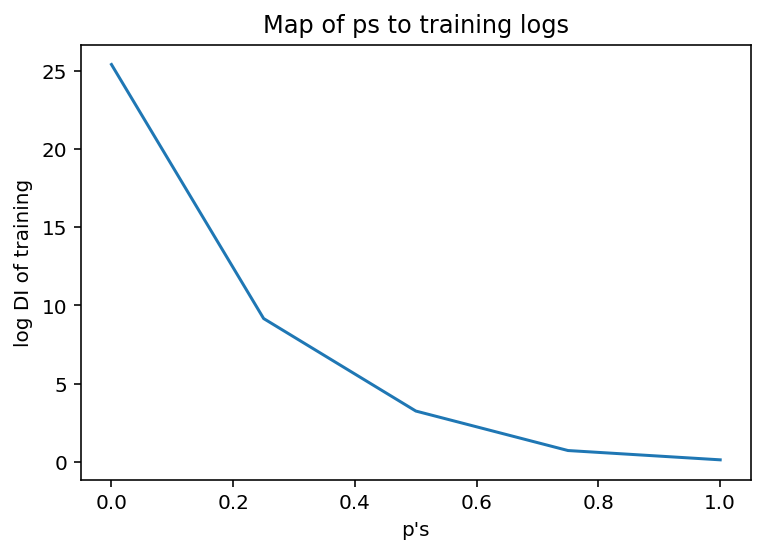

In [64]:
plt.plot(p_vals, logs_training)
plt.title("Map of ps to training logs")
plt.xlabel("p's")
plt.ylabel("log DI of training")

Text(0,0.5,'log DI of test')

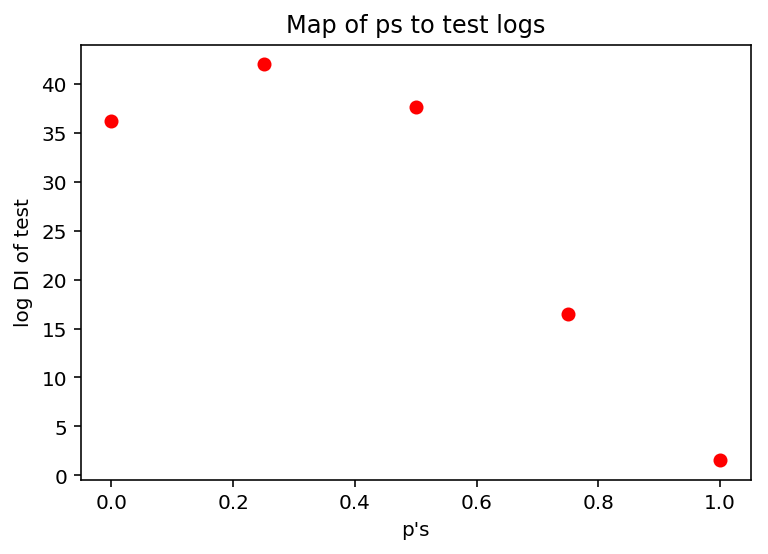

In [65]:
plt.plot(p_vals, logs_test, "ro")
plt.title("Map of ps to test logs")
plt.xlabel("p's")
plt.ylabel("log DI of test")

Text(0,0.5,'log DI of test')

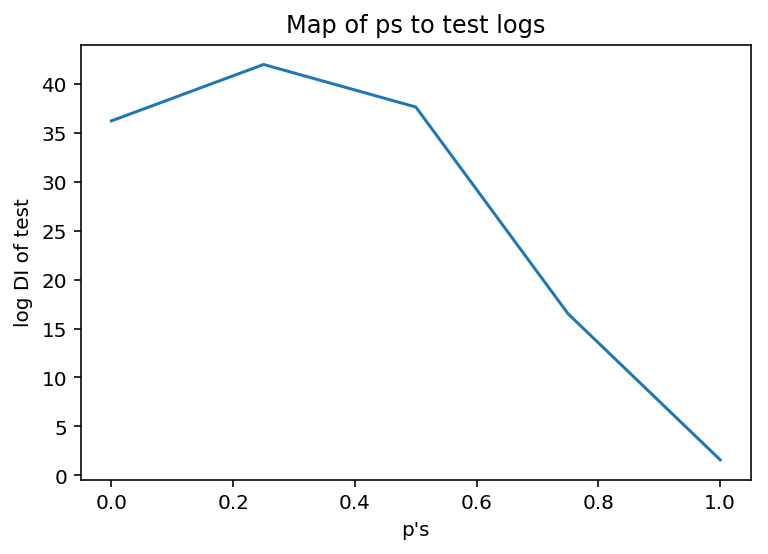

In [66]:
plt.plot(p_vals, logs_test)
plt.title("Map of ps to test logs")
plt.xlabel("p's")
plt.ylabel("log DI of test")

In [67]:
#xs_all_logs = []
# print(ys_all_logs)
#for i in range(len(ys_all_logs)):
#    xs_all_logs.append(ys_all_logs[i])
#print(xs_all_logs)
#print(all_logs_training)

xs_all_logs = np.concatenate(xs_all_logs, axis=None)
#print(xs_all_logs)
#print(len(xs_all_logs))
print(xs_all_logs)
for i in range(len(xs_all_logs)):
    xs_all_logs[i] = 1 - xs_all_logs[i] # NP: What's going on here? 
print(xs_all_logs)

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75
 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75
 0.75 0.75 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.  ]
[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.75 0.75 0.75
 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75
 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5 

In [68]:
all_logs_training = np.concatenate(all_logs_training, axis = None)
print(all_logs_training)
print(xs_all_logs)
all_logs_test = np.concatenate(all_logs_test, axis = None)

[25.39929983 25.39929983 25.39929983 25.39929983 25.39929983 25.39929983
 25.39929983 25.39929983 25.39929983 25.39929983 25.39929983 25.39929983
 25.39929983 25.39929983 25.39929983 25.39929983 25.39929983 25.39929983
 25.39929983 25.39929983 25.39929983 25.39929983 25.39929983 25.39929983
 25.39929983 10.6209121   9.26618044  9.37012443  8.51676417  9.69454419
  9.95213668 10.14105538 11.05490947  8.0084339   9.40944889  8.6888552
  9.39463218  9.13097632  8.85802471  9.05549951  8.07359797  8.8035867
  7.5012298   9.39738508  9.66377101  8.56585893  8.43855444  8.99343812
  9.63109868  8.91908475  4.28293427  2.8286824   2.87046162  3.29992594
  3.34120968  3.47290384  3.20010013  2.9828429   2.92792725  2.54238591
  3.58285535  3.02397873  3.54430723  3.32511672  3.17266359  3.63118519
  3.14640582  3.34834934  4.78371812  4.10758052  2.54415161  2.26986066
  2.79596676  3.23621783  3.12984678  0.37583145  0.6490647   0.4537247
  1.19438129  0.72407772  0.54967954  0.54723149  0.60

In [110]:
results.head()

,p,logDI_train,logDI_test
0,0.0,25.3993,36.212228
1,0.0,25.3993,36.212228
2,0.0,25.3993,36.212228
3,0.0,25.3993,36.212228
4,0.0,25.3993,36.212228


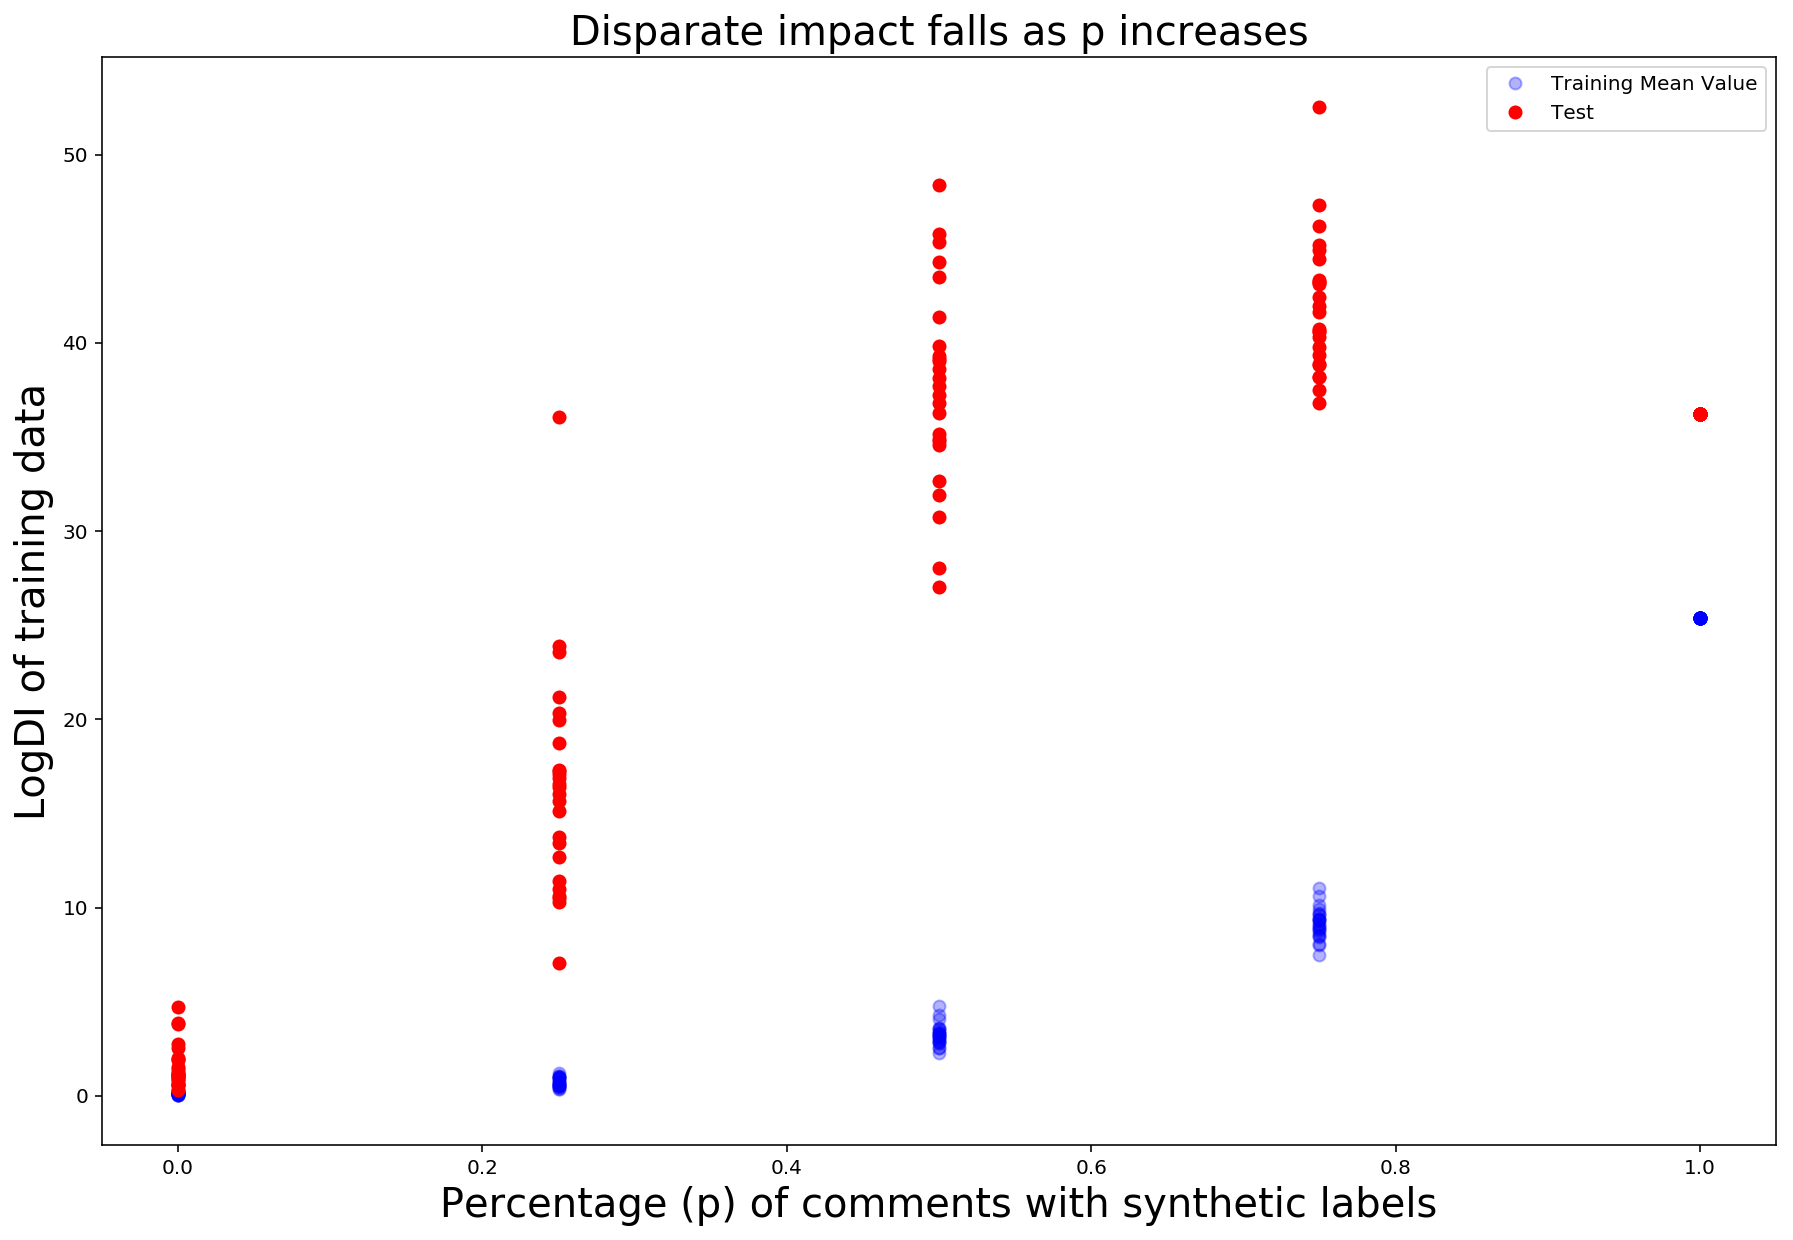

In [106]:
plt.figure(figsize=(15,10))
# blue is training

plt.plot(xs_all_logs, all_logs_training, "bo", alpha = .3, label = "Training Mean Value")
# NP: How is this "Training Mean Value?"

# plt.plot(p_vals, logs_training, "blue", label = "Training")
# NP: I suppose this is what you meant by Training Mean Value?

# red will be test
# plt.plot(p_vals, logs_test, "red", alpha = .3, label = "Test Mean Value")
plt.plot(xs_all_logs, all_logs_test, "ro", label = "Test")

plt.plot()
plt.title("Disparate impact falls as p increases", fontsize=20)
plt.xlabel("Percentage (p) of comments with synthetic labels", fontsize=20)
plt.ylabel("LogDI of training data", fontsize=20)
plt.savefig('DI_tr_data_p_incr.png', bbox_inches='tight')
plt.legend()

In [70]:
# plt.plot(ys_all_logs, all_logs_test)
# plt.title("Map of not-avg ps to test logs")
# plt.xlabel("p's")
# plt.ylabel("log DI of test")

NP: Neha asks that I wait to "investigate" the following three cells until after I run and save the above code.

In [ ]:
df_perturbed_training = pd.DataFrame(list_training)
df_perturbed_training = df_perturbed_training.T
df_perturbed_training.columns=p_vals
df_perturbed_training.to_csv("perturbed_training2.csv", index=False)
df_perturbed_test = pd.DataFrame(list_test)
df_perturbed_test = df_perturbed_test.T
df_perturbed_test.columns=p_vals
df_perturbed_training.to_csv("perturbed_test2.csv", index=False)

In [ ]:
df_perturbed_training.head()

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(p_vals, logs_test, "ro", label='test Dataset')
plt.plot(p_vals, logs_training, "o", label='Training Dataset')
plt.legend()